### **IMPORTING LIBRARIES**

In [1]:
#importing libraries
from google.colab import drive
drive.mount('/content/drive')
import torch
import warnings
warnings.filterwarnings("ignore")
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from __future__ import print_function,division
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torch import optim
import time
from torch.nn.modules.activation import ReLU
import tqdm
!pip install split-folders
import splitfolders
import os
from sklearn import metrics
import copy
import matplotlib.pyplot as plt
cudnn.benchmark=True
plt.ion()

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #setting device to GPU

### **DATA PREPROCESSING**

In [3]:
data_transforms={'train':transforms.Compose([transforms.RandomResizedCrop(224)
,transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize([0.47949,0.4665, 0.4086],[0.2849, 0.2770, 0.2849])]),
'val':transforms.Compose([transforms.Resize(256)
,transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.47949, 0.4665, 0.4086],[0.2849, 0.2770, 0.2849])]),
'test':transforms.Compose([transforms.Resize(256)
,transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.47949, 0.4665, 0.4086],[0.28491, 0.2770, 0.2849])])
}


### **SPLITTING TRAINING DATA INTO TRAIN AND VALIDATION DATA(80/20 split)**

In [4]:
input_folder = '/content/drive/MyDrive/FT_1/assignment1_data/classification_dataset/train'
output_folder = '/content/drive/MyDrive/FT_1/assignment1_data/classification_dataset/train_split'
splitfolders.ratio(input_folder, output = output_folder, seed = 1337, ratio = (0.8, 0.2), group_prefix=None, move = False )

Copying files: 532 files [01:19,  6.67 files/s]


### **LOADING TRAINING DATA USING DATA LOADER** 

In [5]:
data_dir_full = '/content/drive/MyDrive/FT_1/assignment1_data/classification_dataset/'
data_dir = '/content/drive/MyDrive/FT_1/assignment1_data/classification_dataset/train_split'

image_datasets={x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}

image_datasets['test']=datasets.ImageFolder(os.path.join(data_dir_full,'test'),data_transforms['test'])

#loading data into data_loader in batches
dataloaders={x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True,num_workers=4) for x in ['train','val','test']}

dataset_sizes={x: len(image_datasets[x]) for x in ['train','val','test']}

class_names=image_datasets['train'].classes

print(dataset_sizes)

print(class_names)

{'train': 423, 'val': 109, 'test': 120}
['bear', 'butterfly', 'camel', 'chimp', 'duck', 'elephant']


###**Defining layers and parameters of CNN**

In [6]:
class ConvNet(nn.Module):
  def __init__(self,num_classes=6):
    super (ConvNet,self).__init__()
    #1st convolution layer with 16 outputs and relu activation function,max pooling 
    self.layer1=nn.Sequential(
        nn.Conv2d(3,16,kernel_size=5,stride=1,padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    #2nd convolution layer with 32 outputs and relu activation function,max pooling
    self.layer2=nn.Sequential(
        nn.Conv2d(16,32,kernel_size=5,stride=1,padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    ) 
    self.layer3=nn.Sequential(
        nn.Conv2d(32,64,kernel_size=5,stride=1,padding=0),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(output_size = (1,1))
    ) 
   
    #linear fully connected layer
    self.fc1=nn.Linear(64, num_classes)

  def forward(self,x):
    out=self.layer1(x)
    out=self.layer2(out)
    out=self.layer3(out)
    out = out.reshape(out.size(0), -1)
    out=self.fc1(out)
    return out



###**Loading CNN model**


In [7]:
model=ConvNet(6).to(device)
model=model.to(device)
criterion=nn.CrossEntropyLoss()  #using cross entropy loss
optimizer_ft=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)  #using Adam optimizer
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)  #scheduler with 10% learning rate depreciation every 7 steps

###**TRAINING MODEL**

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    accuracies=[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_accuracies=[]
    val_accuracies=[]
    test_accuracies=[]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val','test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                if phase !='test':
                  running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase =='test':
              print(f'{phase}  Acc: {epoch_acc:.4f}')
            else:
              print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
 
            #Accuracy for each epoch of respective phase
            if phase == 'train':
              train_accuracies.append(epoch_acc)
            elif phase == 'val':
              val_accuracies.append(epoch_acc)
            elif phase == 'test':
              test_accuracies.append(epoch_acc)
            
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    accuracies.append(train_accuracies)
    accuracies.append(val_accuracies)
    accuracies.append(test_accuracies)
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,accuracies

In [9]:
model,accuracies=train_model(model,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=30) #training the final model

Epoch 0/29
----------
train Loss: 1.7902 Acc: 0.2080
val Loss: 1.6148 Acc: 0.3303
test  Acc: 0.3250

Epoch 1/29
----------
train Loss: 1.7183 Acc: 0.2955
val Loss: 1.5912 Acc: 0.3211
test  Acc: 0.3583

Epoch 2/29
----------
train Loss: 1.7016 Acc: 0.3144
val Loss: 1.5311 Acc: 0.3670
test  Acc: 0.4500

Epoch 3/29
----------
train Loss: 1.6806 Acc: 0.3144
val Loss: 1.5459 Acc: 0.3578
test  Acc: 0.3667

Epoch 4/29
----------
train Loss: 1.6614 Acc: 0.2979
val Loss: 1.5613 Acc: 0.3670
test  Acc: 0.3417

Epoch 5/29
----------
train Loss: 1.7236 Acc: 0.3073
val Loss: 1.4888 Acc: 0.3853
test  Acc: 0.4250

Epoch 6/29
----------
train Loss: 1.6844 Acc: 0.2837
val Loss: 1.5232 Acc: 0.3945
test  Acc: 0.4417

Epoch 7/29
----------
train Loss: 1.6369 Acc: 0.3191
val Loss: 1.4927 Acc: 0.4037
test  Acc: 0.4500

Epoch 8/29
----------
train Loss: 1.6231 Acc: 0.3310
val Loss: 1.4894 Acc: 0.4037
test  Acc: 0.4583

Epoch 9/29
----------
train Loss: 1.6426 Acc: 0.3499
val Loss: 1.4848 Acc: 0.4037
test  Acc

###**PLOTTING ACCURACIES VS EPOCHS**

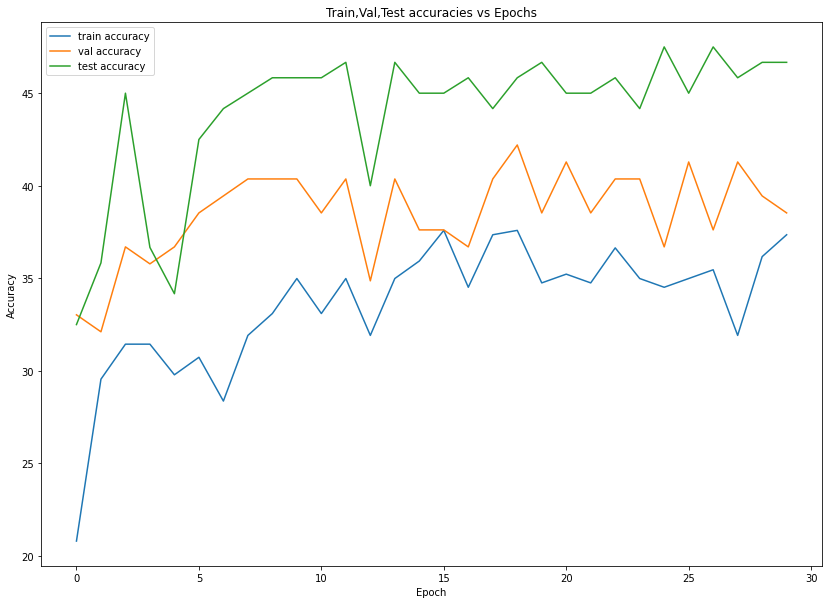

In [10]:
accuracies=torch.tensor(accuracies,device='cpu').numpy()
fig = plt.figure(figsize=(14,10))
for i in accuracies:
  plt.plot(i*100)
  plt.legend(['train accuracy','val accuracy','test accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Train,Val,Test accuracies vs Epochs")
  plt.savefig('NN_accuracy-vs-epoch')

### **LOADING TEST DATA**

In [11]:
data_dir_1 = '/content/drive/MyDrive/FT_1/assignment1_data/classification_dataset/'
image_datasets={x: datasets.ImageFolder(os.path.join(data_dir_1,x),data_transforms[x]) for x in ['test']}
dataloaders_test={x: torch.utils.data.DataLoader(image_datasets[x], batch_size=120,shuffle=False,num_workers=2) for x in ['test']}

### **CALCULATING TEST ACCURACY**

In [12]:
def test_model(dataloaders_test,model):
  correct_count=0
  images_so_far = 0
  y_true=[]
  y_pred=[]
  fig = plt.figure(figsize=(15, 15))
  for i, (inputs, labels) in enumerate(dataloaders_test['test']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(inputs.size()[0]):
      images_so_far += 1
      y_true.append(class_names[labels[j]])
      y_pred.append(class_names[preds[j]])  
      if(class_names[labels[j]]==class_names[preds[j]]):
        correct_count+=1
  print("Accuracy: ")
  print(correct_count/images_so_far)
  print("----------------------------")
  print("Classification Report:")
  report=metrics.classification_report(y_true, y_pred)
  print(report)
  print("----------------------------")
  print("Confusion Matrix:")
  cf_matrix=metrics.confusion_matrix(y_true, y_pred)
  print(cf_matrix)

In [13]:
test_model(dataloaders_test,model)

Accuracy: 
0.4583333333333333
----------------------------
Classification Report:
              precision    recall  f1-score   support

        bear       0.33      0.10      0.15        20
   butterfly       0.54      0.70      0.61        20
       camel       0.44      0.80      0.57        20
       chimp       0.58      0.55      0.56        20
        duck       0.50      0.20      0.29        20
    elephant       0.32      0.40      0.36        20

    accuracy                           0.46       120
   macro avg       0.45      0.46      0.42       120
weighted avg       0.45      0.46      0.42       120

----------------------------
Confusion Matrix:
[[ 2  3  6  2  1  6]
 [ 0 14  2  1  1  2]
 [ 1  2 16  0  0  1]
 [ 1  3  0 11  0  5]
 [ 1  4  6  2  4  3]
 [ 1  0  6  3  2  8]]


<Figure size 1080x1080 with 0 Axes>